In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import tensorboard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

from tensorflow.keras.metrics import Precision, Accuracy
from tensorflow.keras.metrics import SensitivityAtSpecificity, SpecificityAtSensitivity
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from tensorflow.keras.models import Model
import cv2

In [3]:
# Set the input shape and number of classes
img_width, img_height = 224, 224
num_classes = 2
NUM_EPOCS = 50
POOL_SIZE = (2,2)
DROP_OUT = 0.5
SIZE_KERNEL = (3,3)

In [4]:
# Set up the data generators
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/Dataset_Clean/Lung_Opacity_vs_Normal/train', 
                                                    target_size=(img_width, img_height), batch_size=32, 
                                                    class_mode='categorical')

test_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/Dataset_Clean/Lung_Opacity_vs_Normal/val', 
                                                  target_size=(img_width, img_height), batch_size=32, 
                                                  class_mode='categorical')

Found 8892 images belonging to 2 classes.
Found 3006 images belonging to 2 classes.


In [5]:
train_generator.class_indices

{'Lung_Opacity': 0, 'Normal': 1}

In [6]:
# Clear any logs from previous runs(uncomment the below line in case of google colab!)
# !rm -rf ./logs/ 

# Define the Keras TensorBoard callback.
logdir = "/content/drive/MyDrive/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# To save the training history
csv_logger = CSVLogger("/content/drive/MyDrive/Trainig_History.csv", append=True)

In [7]:
checkpoint_filepath = "/content/drive/MyDrive/Lung_Opacity_Normal.h5"
SAVE_BEST_ONLY = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', verbose=0, 
                                 save_best_only=True, mode='auto')

CALLBACKS = [tensorboard_callback, csv_logger, SAVE_BEST_ONLY]

In [8]:
# Define the model architecture
model = Sequential()
model.add(Conv2D(32, SIZE_KERNEL, activation='relu', input_shape=(img_width, img_height, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(POOL_SIZE))
model.add(Conv2D(64, SIZE_KERNEL, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(POOL_SIZE))
model.add(Conv2D(128, SIZE_KERNEL, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(POOL_SIZE))
model.add(Conv2D(256, SIZE_KERNEL, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(POOL_SIZE))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(DROP_OUT))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'TruePositives',
                                                                          'TrueNegatives', 'FalsePositives', 'FalseNegatives', 
                                                                          tf.keras.metrics.SpecificityAtSensitivity(0.5), 
                                                                          tf.keras.metrics.SensitivityAtSpecificity(0.5)])
model.summary()

# Train the model
history = model.fit(train_generator, epochs=NUM_EPOCS, validation_data=test_generator, callbacks=CALLBACKS, steps_per_epoch=50)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 64)     256       
 hNormalization)                                                 
                                                        

In [9]:
# Evaluate the model
loss, accuracy,*_ = model.evaluate(test_generator)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

94/94 [==============================] - 13s 136ms/step - loss: 0.6925 - accuracy: 0.7219 - precision: 0.7219 - recall: 0.7219 - true_positives: 2170.0000 - true_negatives: 2170.0000 - false_positives: 836.0000 - false_negatives: 836.0000 - specificity_at_sensitivity: 0.8466 - sensitivity_at_specificity: 0.8466
Test Loss: 0.6925449371337891
Test Accuracy: 0.7218895554542542


In [10]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
cm = confusion_matrix(y_true, y_pred_classes)

cm
# sns.heatmap(cm, annot=True, cmap="Blues")
# plt.show()

94/94 [==============================] - 13s 133ms/step


array([[1092,  411],
       [1129,  374]])

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {"/content/drive/MyDrive/fit/"}

In [ ]:
# its not needed but just in case
for idx in range(len(model.layers)):
  print(model.get_layer(index = idx).name)

conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2
max_pooling2d_2
conv2d_3
max_pooling2d_3
flatten
dense
dropout
dense_1


In [ ]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [ ]:
image = cv2.imread('normal.png')
image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

preds = model.predict(image) 
i = np.argmax(preds[0])
if i == 0:
  print('The patient has Lung Opacity')
else:
  print("The patient is Normal")

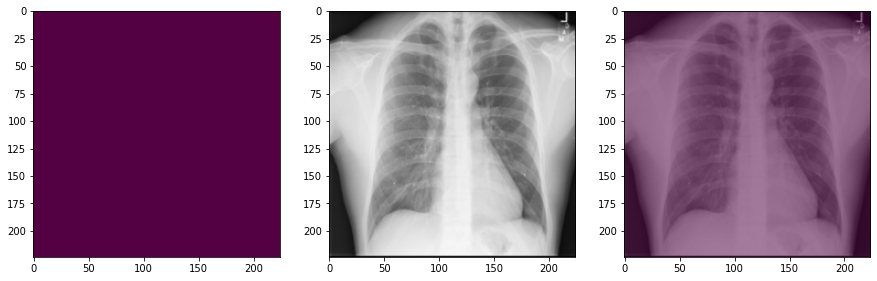

In [ ]:
icam = GradCAM(model, i) 
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (224, 224))

image = cv2.imread('normal.png')
image = cv2.resize(image, (224, 224))
# print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

fig, ax = plt.subplots(1, 3, figsize=(15, 15))

# ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)